In [375]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [376]:
dataset_train = pd.read_csv("xtrain_final.csv", sep = ',')
dataset_test = pd.read_csv("xtest_final.csv", sep = ',')
dataset_train.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset_test.drop(['Unnamed: 0','var11', 'var7_1.1','var7_2.1','var7_3.1','var7_4.1','var7_5.1',
                   'var7_6.1','var7_7.1','var7_8.1'], axis=1, inplace=True)

In [377]:
weather=[]
for i in range(1,49):
    weather.append('weahter_trim'+str(i))

In [378]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
weather_train_minmax = min_max_scaler.fit_transform(dataset_train[weather])
weather_test_minmax = min_max_scaler.fit_transform(dataset_test[weather])

pca = PCA()
weather_pca_train = pca.set_params(n_components = 2).fit_transform(weather_train_minmax)
weather_pca_test = pca.transform(weather_test_minmax)

In [379]:
df_wea_pca_train = pd.DataFrame(weather_pca_train, columns=['pca_wea1', 'pca_wea2'])
df_wea_pca_test = pd.DataFrame(weather_pca_test, columns=['pca_wea1', 'pca_wea2'])

In [380]:
X_train = pd.concat([dataset_train,df_wea_pca_train], axis = 1)
X_test = pd.concat([dataset_test,df_wea_pca_test], axis = 1)

In [381]:
X_train.drop(weather, axis =1, inplace = True)
X_test.drop(weather, axis =1, inplace = True)

In [382]:
X_train.drop(['pca_crime1','pca_crime2'], axis =1, inplace = True)
X_test.drop(['pca_crime1','pca_crime2'], axis =1, inplace = True)

In [383]:
labels_total = X_train['target_binary']
logloss_total = X_train['logloss']
weights_total = X_train['var11']
target_total = X_train['target']

In [341]:
#X_train.drop(['target_binary','logloss', 'var11', 'target'], axis =1, inplace = True)

In [357]:
X_train.shape

(452061, 74)

In [358]:
X_test.shape

(450728, 70)

# Take Sample to do training

In [384]:
df_fires = X_train[X_train.target > 0]
df_fires_noloss = X_train[X_train.target == 0].iloc[:100000]

In [385]:
train = pd.concat([df_fires, df_fires_noloss], axis = 0)

In [386]:
labels = train['target_binary']
logloss = train['logloss']
weights = train['var11']
target = train['target']

In [387]:
train.drop(['var11','target_binary','target', 'logloss'], axis=1, inplace=True)

In [388]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(labels, n_folds=5, shuffle=False, random_state=2015)
for train_index, test_index in skf:
#    print train_index, test_index
    X_sample_train, X_sample_test = train.iloc[train_index], train.iloc[test_index]
    y_sample_train, y_sample_test = labels.iloc[train_index], labels.iloc[test_index]
    log_train, log_test = logloss.iloc[train_index], logloss.iloc[test_index]
    target_train, target_test = target.iloc[train_index], target.iloc[test_index]
    w_train, w_test = weights.iloc[train_index], weights.iloc[test_index]

In [389]:
def weighted_gini(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
    #df["gini"] = (df.lorentz - df.random) * df.weight
    #return df.gini.sum()
    gini = sum(df.lorentz[1:].values * (df.random[:-1])) - sum(df.lorentz[:-1].values * (df.random[1:]))
    return gini

def normalized_weighted_gini(act,pred,weight):
    return weighted_gini(act,pred,weight) / weighted_gini(act,act,weight)

In [390]:
import sklearn.metrics
import time

def evaluate_model(clf):
    """Scores a model using log loss with the created train and test sets."""
    start = time.time()
#    clf.fit(X_train, y_train)
    print "Train score:", sklearn.metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    print "Test score:", sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    print "train gini score:", normalized_weighted_gini(clf.predict_proba(X_train)[:,1], y_train, w_train)
    print "test gini score:", normalized_weighted_gini(clf.predict_proba(X_test)[:,1], y_test, w_test)
    print "Total time:", time.time() - start
    print

# Logistic Regression

In [20]:
# Scaling the varaibles is often useful and will make the model converge more quickly.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([('scale', MinMaxScaler()), ('classifier', LogisticRegression())])
evaluate_model(pipe)

Train score: 0.689284056257
Test score: 0.653257278481
train gini score: 0.0169885904482
test gini score: 0.0183222467795
Total time: 2.05951809883



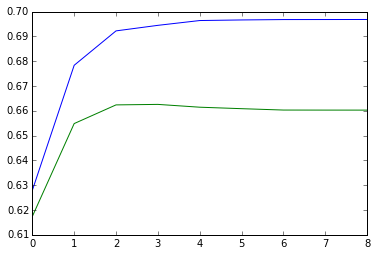

In [21]:
import sklearn.learning_curve

C_values = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 1000]
train_scores, test_scores = sklearn.learning_curve.validation_curve(pipe, X_train, y_train,
                                                                    'classifier__C', C_values, scoring='roc_auc')
plt.plot(np.mean(train_scores, axis=1), label='Train')
plt.plot(np.mean(test_scores, axis=1), label='Test')

In [15]:
from sklearn.grid_search import GridSearchCV

C_values = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 1000]
penalty_values = ['l1']

params = [{'classifier__C' : C_values, 'classifier__penalty': penalty_values}]
grid = GridSearchCV(pipe, params, cv=2, scoring='roc_auc')
evaluate_model(grid)
grid.grid_scores_

Train score: 0.698736409043
Test score: 0.65465685654
train gini score: 0.0180167317276
test gini score: 0.0111118607677
Total time: 1996.12573695



[mean: 0.50000, std: 0.00000, params: {'classifier__C': 0.01, 'classifier__penalty': 'l1'},
 mean: 0.63984, std: 0.00706, params: {'classifier__C': 0.1, 'classifier__penalty': 'l1'},
 mean: 0.65590, std: 0.00327, params: {'classifier__C': 0.5, 'classifier__penalty': 'l1'},
 mean: 0.65936, std: 0.00428, params: {'classifier__C': 1, 'classifier__penalty': 'l1'},
 mean: 0.65700, std: 0.00292, params: {'classifier__C': 5, 'classifier__penalty': 'l1'},
 mean: 0.65494, std: 0.00187, params: {'classifier__C': 10, 'classifier__penalty': 'l1'},
 mean: 0.65488, std: 0.00118, params: {'classifier__C': 50, 'classifier__penalty': 'l1'},
 mean: 0.65484, std: 0.00104, params: {'classifier__C': 100, 'classifier__penalty': 'l1'},
 mean: 0.65466, std: 0.00132, params: {'classifier__C': 1000, 'classifier__penalty': 'l1'}]

# Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

#evaluate_model(gbt)
gbm = GradientBoostingClassifier(max_features=10, n_estimators=500, 
                                 learning_rate=0.05, random_state= 2015)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=10, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              random_state=2015, subsample=1.0, verbose=0,
              warm_start=False)

In [33]:
print sklearn.metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1])
print sklearn.metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])
print "train gini score:", normalized_weighted_gini(gbm.predict_proba(X_train)[:,1], y_train, w_train)
print "test gini score:", normalized_weighted_gini(gbm.predict_proba(X_test)[:,1], y_test, w_test)

0.828096142219
0.663708122363
train gini score: 0.130474435254
test gini score: 0.0132713907171


In [34]:
def plot_gbt_learning(gbt):
    test_score = np.empty(len(gbt.estimators_))
    train_score = np.empty(len(gbt.estimators_))
    for i, pred in enumerate(gbt.staged_predict_proba(X_test)):
         test_score[i] = sklearn.metrics.roc_auc_score(y_test, pred[:,1])
    #    test_score[i] = sklearn.metrics.log_loss(y_test, pred)
    for i, pred in enumerate(gbt.staged_predict_proba(X_train)):
         train_score[i] = sklearn.metrics.roc_auc_score(y_train, pred[:,1])
    #    train_score[i] = sklearn.metrics.log_loss(y_train, pred)
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(gbt.n_estimators) + 1, test_score, label='Test') 
    plt.plot(np.arange(gbt.n_estimators) + 1, train_score, label='Train')

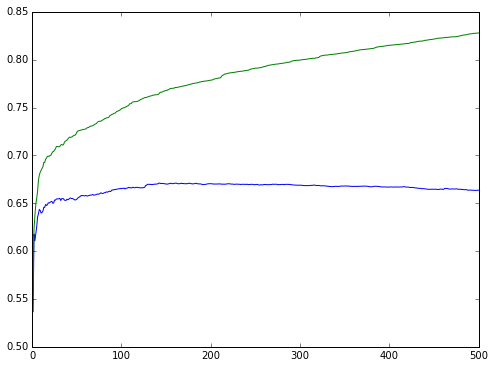

In [36]:
plot_gbt_learning(gbm)

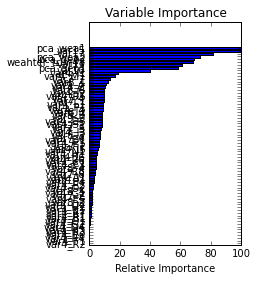

In [231]:
feature_importance = gbm.feature_importances_ 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# GBR

In [391]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [392]:
#evaluate_model(gbr)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05)
gbr.fit(X_sample_train, target_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.05, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [395]:
#print sklearn.metrics.log_loss(y_train, gbr.predict(X_train))
#print sklearn.metrics.log_loss(y_test, gbr.predict(X_test))
print "train gini score:", normalized_weighted_gini(gbr.predict(X_sample_train), target_train, w_train)
print "test gini score:", normalized_weighted_gini(gbr.predict(X_sample_test), target_test, w_test)

train gini score: 0.0431735781728
test gini score: 0.0176712074271


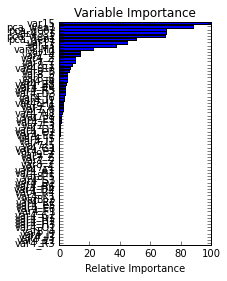

In [372]:
feature_importance = gbr.feature_importances_ 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


# XGBOOST

In [70]:
import scipy as sp
from sklearn.cross_validation import KFold
import xgboost as xgb

def estimate_performance_xgboost(X,labels,weights, param, num_round, folds):
    '''
    Cross validation for XGBoost performance
    '''
    # Load training data
#     f=open("summary_bst_scan.txt","a")
#     X, labels, weights = get_training_data(training_file)
#    f=open("summary_bst_scan.txt","a")
    # Cross validate
    npoints  =30
    kf = KFold(labels.size, n_folds=folds, random_state=4234)

    # Dictionary to store all the AMSs#    ams_best_idall_AMS = {}
    all_GINI = []
#    summay_table=[]
#     for curr in range(npoints):
#         all_AMS[curr] = []
    # These are the cutoffs used for the XGBoost predictions
    cutoffs  = sp.linspace(0.10, 0.40, npoints)
    for train_indices, test_indices in kf:
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = labels.iloc[train_indices], labels.iloc[test_indices]
        w_train, w_test = weights.iloc[train_indices], weights.iloc[test_indices]

        # Rescale weights so that their sum is the same as for the entire training set
        w_train *= (sum(weights) / sum(w_train))
        w_test  *= (sum(weights) / sum(w_test))

        sum_wpos = sum( weights[i] for i in range(len(labels)) if labels[i] > 0.0  )
        sum_wneg = sum( weights[i] for i in range(len(labels)) if labels[i] == 0.0  )    
        if (sum_wneg>  sum_wpos*100000):
            sum_wpos=1000*sum_wneg
        # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#        xgmat = xgb.DMatrix(X_train, label=y_train, missing=-999.0, weight=w_train)
        xgmat = xgb.DMatrix(X_train, label=y_train, weight=w_train)

        # scale weight of positive examples
        param['scale_pos_weight'] = sum_wneg / sum_wpos
        
        # you can directly throw param in, though we want to watch multiple metrics here
        plst = param.items()#+[('eval_metric', 'ams@0.15')]

        watchlist = []#[(xgmat, 'train')]
        bst = xgb.train(plst, xgmat, num_round, watchlist)

        # Construct matrix for test set
#        xgmat_test = xgb.DMatrix(X_test, missing=-999.0)
        xgmat_test = xgb.DMatrix(X_test)
        y_out = bst.predict(xgmat_test)
#        num=y_test.shape[0]
#        y_test=np.reshape(y_test,num)
#         print((y_test).shape)
        gini_score=normalized_weighted_gini(y_test,y_out,w_test)
        print('gini_score={}'.format(gini_score))
#        f.write('gini_score={}'.format(gini_score))
#        f.write('\n')
        all_GINI.append(gini_score)
    print ("------------------------------------------------------")
    print ("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
#    f.write("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
#    f.write('\n')
#    f.close()

In [77]:
params1 = {'objective': 'binary:logistic',
              'eta': 0.1,
              'subsample': 0.75,
              'max_depth': 6,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 0,
              'silent': 1}

folds = 5 
num_round = 50 # Number of boosted trees

xgb1 = estimate_performance_xgboost(X_train, labels ,weights, params1, num_round, folds)

gini_score=0.256209258992
gini_score=0.180353934642
gini_score=0.238857578656
gini_score=0.243307813876
gini_score=0.313345054756
------------------------------------------------------
mean Gimi =0.246414728185 with std=0.0424414733903


In [80]:
params2 = {'objective': 'count:poisson',
              'eta': 0.1,
              'subsample': 0.7,
              'max_depth': 6,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 5,
              'silent': 1
              }

folds = 5 
num_round = 10 
xgb2 = estimate_performance_xgboost(X_train, logloss, weights, params2, num_round, folds)

gini_score=0.337331162398
gini_score=0.187313740359
gini_score=0.255579834881
gini_score=0.2449387894
gini_score=0.260293833861
------------------------------------------------------
mean Gimi =0.25709147218 with std=0.0478906412793


In [81]:
params3 = {'objective': 'reg:linear',
              'eta': 0.1,
              'subsample': 0.9,
              'max_depth': 9,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 5,
              'silent': 1
              }
folds = 5 
num_round = 10 
xgb3 = estimate_performance_xgboost(X_train, logloss, weights, params3, num_round, folds)

gini_score=0.283026033193
gini_score=0.166475770954
gini_score=0.154670224864
gini_score=0.24769579225
gini_score=0.233623849113
------------------------------------------------------
mean Gimi =0.217098334075 with std=0.0490217733699


In [408]:
##pick POINSSON for training all training data again
##Poinsson 
sum_wpos = sum( weights_total[i] for i in range(len(target_total)) if target_total[i] > 0.0  )
sum_wneg = sum( weights_total[i] for i in range(len(target_total)) if target_total[i] == 0.0  )    
if (sum_wneg>  sum_wpos*100000):
    sum_wpos=1000*sum_wneg

xgmat = xgb.DMatrix(X_train, label=target_total, weight=weights_total)    
    
params2 = {'objective': 'count:poisson',
           'eta': 0.05,
              'max_depth': 6,
             'subsample': 0.8,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 6,
              'silent': 1,
              'scale_pos_weight':sum_wneg / sum_wpos
              }

num_round = 24

xgb_poinsson = xgb.train(params2, xgmat,num_round)

In [410]:
##pick Logistic for training all training data again
xgmat = xgb.DMatrix(X_train, labels_total, weight=weights_total)    
 
params1 = {'objective': 'binary:logistic',
              'eta': 0.05,
              'max_depth': 6,
              'subsample': 0.8,
              'min_child_weight': 1,
              'colsample_bytree': 0.5,
              'gamma': 6,
              'silent': 1,
              'scale_pos_weight':sum_wneg / sum_wpos}

num_round = 25

xgb_logit = xgb.train(params1, xgmat,num_round)

# blind test set

In [396]:
X_train.drop(['target_binary','logloss', 'var11', 'target'], axis =1, inplace = True)

In [68]:
pred = gbm.predict_proba(X_test)[:,1]
## new dataframe fro submission
data_test_sub=pd.DataFrame({"id":X_test.index,"target":pred})
data_test_sub.to_csv('submission_gbm_reduced.csv',index=False)

In [69]:
pred2 = gbr.predict(X_test)
## new dataframe fro submission
data_test_sub=pd.DataFrame({"id":X_test.index,"target":pred2})
data_test_sub.to_csv('submission_gbr_reduced.csv',index=False)

In [203]:
xgmat_test = xgb.DMatrix(X_test)
pred3 = xgb_poinsson.predict(xgmat_test)
## new dataframe fro submission
data_test_sub=pd.DataFrame({"id":X_test.index,"target":pred3})
data_test_sub.to_csv('submission_xgb_poisson.csv',index=False)

In [122]:
xgmat_test = xgb.DMatrix(X_test)
pred4 = xgb_logit.predict(xgmat_test)
## new dataframe fro submission
data_test_sub=pd.DataFrame({"id":X_test.index,"target":pred4})
data_test_sub.to_csv('submission_xgb_logit.csv',index=False)

# Ensemble

In [426]:
pred_gbr_train = gbr.predict(X_train)
pred_xgbpoisson_train = xgb_poinsson.predict(xgb.DMatrix(X_train))
data_stack=pd.DataFrame({"pred_gbr_train":pred_gbr_train,
                            'pred_xgbpoisson_train':pred_xgbpoisson_train})

In [483]:
stacked_train = pd.concat([X_train,data_stack], axis= 1)

In [496]:
gbr_ensemble = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gbr_ensemble.fit(stacked_train, logloss_total)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [486]:
data_stack_test=pd.DataFrame({"pred_gbr_train":pred2,
                            'pred_xgbpoisson_train':pred3,
                           'pred_xgblogit_train':pred4})
stacked_test = pd.concat([X_test,data_stack_test], axis= 1)

In [495]:
#############
#xgmat_test = xgb.DMatrix(stacked_test)
pred5 = gbr_ensemble.predict(stacked_test)
## new dataframe fro submission
data_test_sub=pd.DataFrame({"id":X_test.index,"target":pred5})
data_test_sub.to_csv('submission_xgb_poisson_refit.csv',index=False)